In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import csv
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from Detection.data_loader import *

In [57]:
from matplotlib import cm
import torchvision.transforms as transforms

In [3]:
path = Path('/data/Datasets/EIPH_WSI/')

database = Database()
database.open(str(path/'EIPH.sqlite'))

files = []
lbl_bbox = []
size = 512

In [4]:
getslides = """SELECT uid, filename FROM Slides"""
for currslide, filename in tqdm(database.execute(getslides).fetchall()):
    database.loadIntoMemory(currslide)

    check = True if 'erliner' in filename else False
    slidetype = 'Berliner Blau/' if check else 'Turnbull Blue/'

    slide_path = path / slidetype / filename

    slide = openslide.open_slide(str(slide_path))
    level = 1#slide.level_count - 1
    level_dimension = slide.level_dimensions[level]
    down_factor = slide.level_downsamples[level]

    classes = {3: 1, 4: 2, 5: 3, 6: 4, 7: 5}
    labels, bboxes = [], []
    for id, annotation in database.annotations.items():
        if annotation.labels[0].classId in classes:
            d = 2 * annotation.r / down_factor
            x_min = (annotation.x1 - annotation.r) / down_factor
            y_min = (annotation.y1 - annotation.r) / down_factor
            x_max = x_min + d
            y_max = y_min + d
            label = classes[annotation.labels[0].classId]

            bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            labels.append(label)

    if len(bboxes) > 0:
        lbl_bbox.append([bboxes, labels])
        files.append(SlideContainer(slide_path, level, size, size))

  0%|          | 0/24 [00:00<?, ?it/s]

Loading DB into memory ...


  4%|▍         | 1/24 [00:00<00:06,  3.52it/s]

Loading DB into memory ...


  8%|▊         | 2/24 [00:01<00:17,  1.23it/s]

Loading DB into memory ...


 12%|█▎        | 3/24 [00:02<00:14,  1.42it/s]

Loading DB into memory ...


 21%|██        | 5/24 [00:02<00:10,  1.87it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 33%|███▎      | 8/24 [00:03<00:06,  2.44it/s]

Loading DB into memory ...
Loading DB into memory ...


 46%|████▌     | 11/24 [00:03<00:04,  3.03it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 50%|█████     | 12/24 [00:03<00:03,  3.05it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 71%|███████   | 17/24 [00:04<00:01,  3.61it/s]

Loading DB into memory ...
Loading DB into memory ...


 79%|███████▉  | 19/24 [00:04<00:01,  3.89it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 88%|████████▊ | 21/24 [00:05<00:00,  3.83it/s]

Loading DB into memory ...
Loading DB into memory ...


100%|██████████| 24/24 [00:06<00:00,  3.71it/s]

Loading DB into memory ...


In [5]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

bs = 64
train_images = 5000
val_images = 500

train_files = list(np.random.choice(files[4:], train_images))
valid_files = list(np.random.choice(files[:4], val_images))

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )

In [6]:
train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min)
data.normalize()

ImageDataBunch;

Train: SlideLabelList
y: SlideObjectCategoryList (5000 items)
[ImageBBox (512, 512), ImageBBox (512, 512), ImageBBox (512, 512), ImageBBox (512, 512), ImageBBox (512, 512)]...
Path: /data/Datasets/EIPH_WSI
x: ObjectItemListSlide (5000 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /data/Datasets/EIPH_WSI;

Valid: SlideLabelList
y: SlideObjectCategoryList (500 items)
[ImageBBox (512, 512), ImageBBox (512, 512), ImageBBox (512, 512), ImageBBox (512, 512), ImageBBox (512, 512)]...
Path: /data/Datasets/EIPH_WSI
x: ObjectItemListSlide (500 items)
[Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512), Image (3, 512, 512)]...
Path: /data/Datasets/EIPH_WSI;

Test: None

In [7]:
def create_regression_head(nf:int, nc:int, y_range=[-0.5,4.5],
                           lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5, bn_final:bool=False):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    lin_ftrs = [nf, 512, nc] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    ps = listify(ps)
    if len(ps)==1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    layers = [AdaptiveConcatPool2d(), Flatten()]
    for ni,no,p,actn in zip(lin_ftrs[:-1],lin_ftrs[1:],ps,actns):
        layers += bn_drop_lin(ni,no,True,p,actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    if y_range is not None: layers.append(SigmoidRange(*y_range))
    return nn.Sequential(*layers)

In [8]:
class L1LossFlat(nn.L1Loss):
    #Mean Absolute Error Loss
    def forward(self, input:Tensor, boxes:Tensor, classes:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1),
                               tensor([p[p > 0].float().mean() - 1 for p in classes]).view(-1).to(input.device))

crit = L1LossFlat()

In [9]:
def mean_absolute_error_box(targ:Tensor, pred:Tensor, classes:Tensor)->Rank0Tensor:
    "Mean absolute error between `pred` and `targ`."
    classes = tensor([p[p > 0].float().mean() - 1 for p in classes]).view(-1).to(targ.device)
    targ = targ.view(-1)
    return torch.abs(targ - classes).mean()

In [10]:
head = create_regression_head(1024, 1)
learn = create_cnn(data, models.resnet18, custom_head=head, loss_func=crit, metrics=mean_absolute_error_box)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


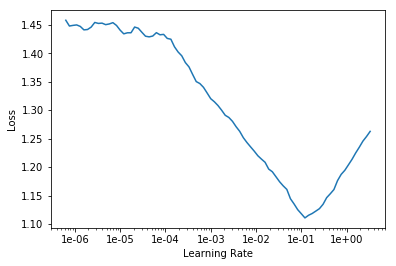

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,mean_absolute_error_box
1,0.736049,0.304171,0.304171
2,0.404279,0.206752,0.206752
3,0.293277,0.192807,0.192807
4,0.255886,0.188710,0.188710
5,0.220399,0.209957,0.209957


In [13]:
learn.unfreeze()

In [14]:
lr = 0.01
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,mean_absolute_error_box
1,0.203638,0.271467,0.271467
2,0.201666,0.209822,0.209822
3,0.217407,0.785560,0.785560
4,0.230622,0.376011,0.376011
5,0.240414,0.399242,0.399242
6,0.222801,0.324422,0.324422
7,0.208264,0.225387,0.225387
8,0.202867,0.163399,0.163399
9,0.189824,0.179969,0.179969
10,0.189522,0.170241,0.170241


In [15]:
learn.save("regression_patch_512")

In [16]:
learn.data.norm

functools.partial(<function _normalize_batch at 0x7f0fe6c742f0>, mean=tensor([0.9308, 0.9098, 0.9199]), std=tensor([0.0632, 0.0747, 0.0567]), do_x=True, do_y=False)

In [55]:
mean, std = [0.9308, 0.9098, 0.9199], [0.0632, 0.0747, 0.0567]

In [17]:
prediction = {}
gt = {}

In [68]:
with torch.no_grad():
    for slide_container in tqdm(files[:1]):
        
        prediction[slide_container.file.name] = []
        gt[slide_container.file.name] = []
        image_bboxes = np.array(img2bbox[slide_container][0])
        image_labels = np.array(img2bbox[slide_container][1])
        
        
        for x in range(0, slide_container.slide.level_dimensions[level][1] - size, int(size / 2)):
            for y in range(0, slide_container.slide.level_dimensions[level][0] - size, int(size / 2)):
                ids = ((image_bboxes[:, 0]) > x) \
                      & ((image_bboxes[:, 1]) > y) \
                      & ((image_bboxes[:, 2]) < x+size) \
                      & ((image_bboxes[:, 3]) < y+size)
                
                gt_score = np.mean(image_labels[ids] - 1) if np.count_nonzero(ids) > 5 else 0
                gt[slide_container.file.name].append(np.array([x, y, gt_score]))
                
                
                patch_ori = slide_container.get_patch(x,y)
                patch = pil2tensor(patch_ori / 255., np.float32)
                patch = transforms.Normalize(mean, std)(patch)
                patch = patch.to(torch.device('cuda'))
                
                pred_score = to_np(learn.model(patch[None, :, :, :])[0])
                
                prediction[slide_container.file.name].append(np.array([x, y, pred_score]))


100%|██████████| 1/1 [00:35<00:00, 35.85s/it]
